In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from itertools import cycle
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import confusion_matrix
colors = cycle(['brown','lightcoral','red','magenta','cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])

In [3]:
def algorithm(algoname,colors,train,test,pos):
    mean_tpr,lw,i =0.0, 2,1
    mean_fpr = np.linspace(0, 1, 100)
    fold_accuracy= []
    cnf_mat = 0
    skfold = StratifiedKFold(n_splits=10,shuffle = True)
    for (trainindex,testindex), color in zip(skfold.split(train, test.values.ravel()), colors):
        X_train, X_test = train.loc[trainindex], train.loc[testindex]
        y_train, y_test = test.loc[trainindex], test.loc[testindex]
        model = algoname.fit(X_train,y_train.values.ravel())
        fold_accuracy.append(model.score(X_test,y_test.values.ravel()))
        result = model.predict(X_test)
        fpr, tpr, thresholds= roc_curve(y_test.values,result,pos_label=pos)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        cm = confusion_matrix(y_test.values,result)
        cnf_mat +=  cm
        plt.step(fpr, tpr, lw=lw, color=color,label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        i+=1
    mean_tpr /= skfold.get_n_splits(train,test.values.ravel())
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.step(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
    plt.title("Average accuracy: {0:.3f}".format(np.asarray(fold_accuracy).mean()))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right") 
    return("Average accuracy: {0:.3f} (+/-{1:.3f})".format(np.asarray(fold_accuracy).mean(),\
                                                            np.asarray(fold_accuracy).std()),\
           "\n Confustion Matrix:",cnf_mat)   


In [4]:
german = pd.read_csv('german.data',header = None, sep = " ")
features = ['Checking account','Duration(month)','Credit history','Purpose',\
           'Credit Amount','Savings/Stocks','Present employment Length',\
           'Installment rate','Personal status','Guarantors',\
           'Residing since','Property','Age(years)','Other installment plans',\
           'Housing','No of credits',\
           'Job','dependents','Telephone','foreign worker']
label = ['Creditability']
columns = features + label
german.columns = columns
for col in german.columns.values:
    if german[col].dtype == 'object':
        german[col] = LabelEncoder().fit_transform(german[col])
german_train,german_test = german[features],german[label]

In [5]:
default = pd.read_excel('default of credit card clients.xls',skiprows=1)
default=default.rename(columns = {'default payment next month':'default'})
default_train,default_test = default.iloc[:,1:len(default.columns)-1],default.iloc[:,len(default.columns)-1]

In [6]:
crx = pd.read_csv('crx.data',header=None,sep = ',')
cols = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15']
classlabel = ['A16']
columns = cols + classlabel
crx.columns = columns
for col in crx.columns.values:
    if crx[col].dtype == 'object':
        crx[col] = LabelEncoder().fit_transform(crx[col])
crx_train, crx_test = crx[cols],crx[classlabel]

Random Forest

('Average accuracy: 0.712 (+/-0.007)', '\n Confustion Matrix:', array([[696,   4],
       [284,  16]]))


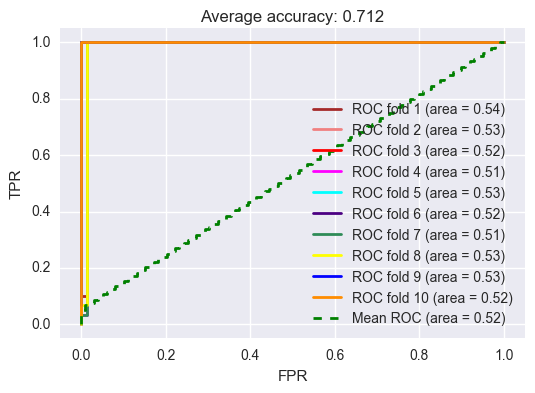

In [7]:
forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=800, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
print(algorithm(forest,colors,german_train,german_test,pos = 2))

('Average accuracy: 0.877 (+/-0.046)', '\n Confustion Matrix:', array([[265,  42],
       [ 43, 340]]))


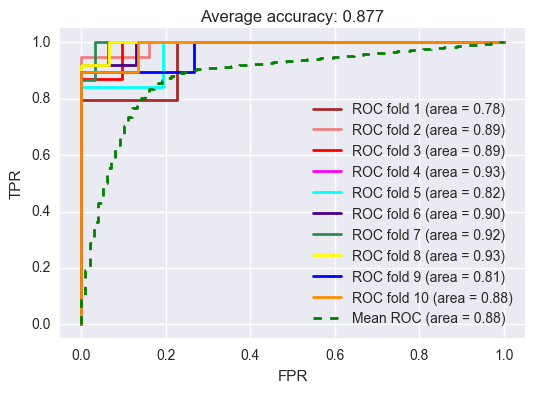

In [8]:
forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=300, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=800, n_jobs=-1, oob_score=False, random_state=100,
            verbose=0, warm_start=False)
print(algorithm(forest,colors,crx_train,crx_test,pos = None))

('Average accuracy: 0.821 (+/-0.005)', '\n Confustion Matrix:', array([[22243,  1121],
       [ 4260,  2376]]))


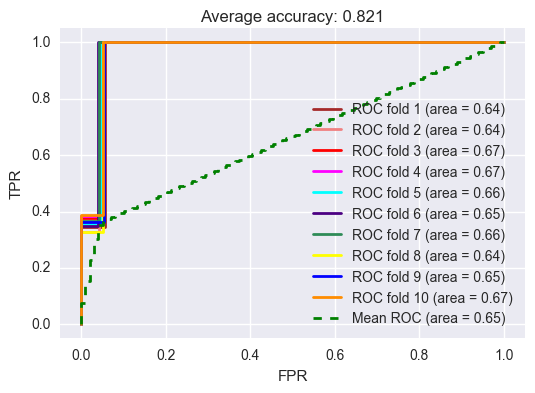

In [9]:
forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
print(algorithm(forest,colors,default_train,default_test,pos = None))

Logistic Regression

('Average accuracy: 0.754 (+/-0.033)', '\n Confustion Matrix:', array([[620,  80],
       [166, 134]]))


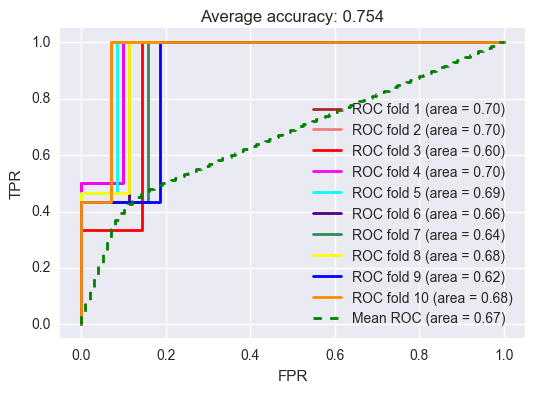

In [10]:
logistic = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=500, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
print(algorithm(logistic,colors,german_train,german_test,pos = 2))

('Average accuracy: 0.868 (+/-0.045)', '\n Confustion Matrix:', array([[275,  32],
       [ 59, 324]]))


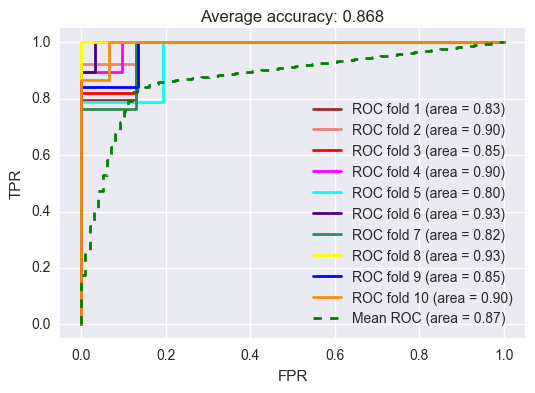

In [11]:
logistic = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
print(algorithm(logistic,colors,crx_train,crx_test,pos = None))

('Average accuracy: 0.810 (+/-0.003)', '\n Confustion Matrix:', array([[22721,   643],
       [ 5044,  1592]]))


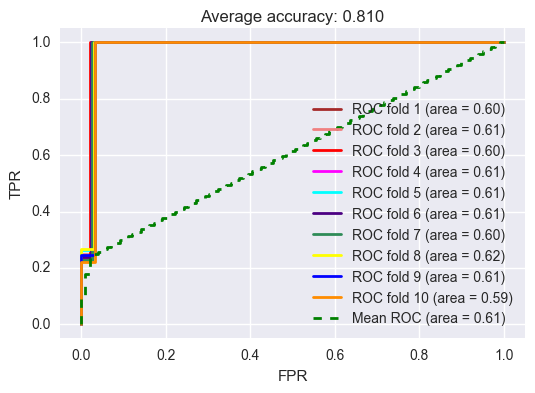

In [12]:
logistic = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
print(algorithm(logistic,colors,default_train,default_test,pos = None))

Naive Bayes

('Average accuracy: 0.725 (+/-0.047)', '\n Confustion Matrix:', array([[543, 157],
       [118, 182]]))


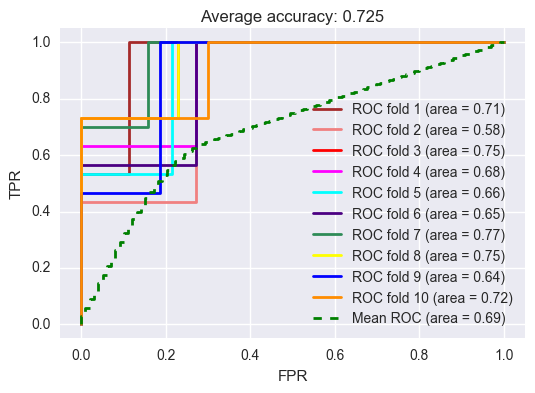

In [13]:
naive = GaussianNB()
print(algorithm(naive,colors,german_train,german_test,pos = 2))

('Average accuracy: 0.787 (+/-0.058)', '\n Confustion Matrix:', array([[194, 113],
       [ 34, 349]]))


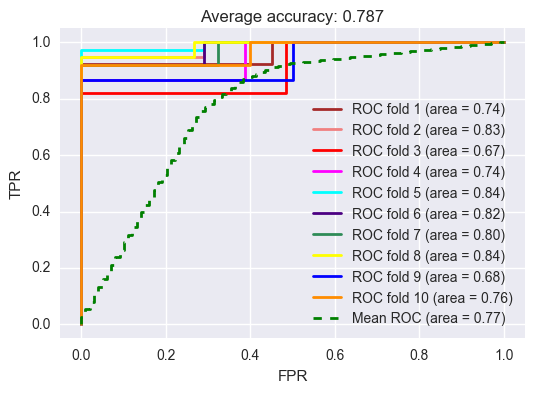

In [14]:
naive = GaussianNB()
print(algorithm(naive,colors,crx_train,crx_test,pos = None))

('Average accuracy: 0.378 (+/-0.010)', '\n Confustion Matrix:', array([[ 5490, 17874],
       [  771,  5865]]))


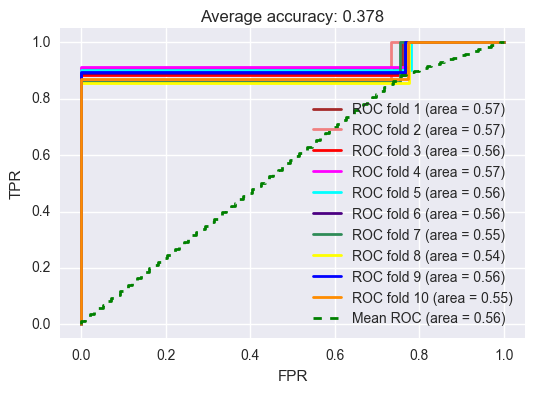

In [15]:
naive = GaussianNB()
print(algorithm(naive,colors,default_train,default_test,pos = None))

k Nearest Neighbors

('Average accuracy: 0.650 (+/-0.039)', '\n Confustion Matrix:', array([[580, 120],
       [230,  70]]))


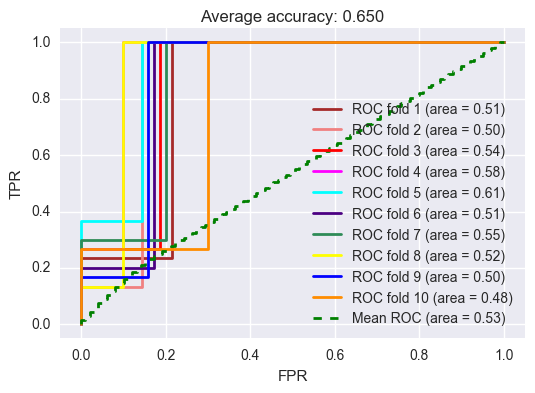

In [16]:
knneigh = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
print(algorithm(knneigh,colors,german_train,german_test,pos = 2))

('Average accuracy: 0.693 (+/-0.048)', '\n Confustion Matrix:', array([[195, 112],
       [100, 283]]))


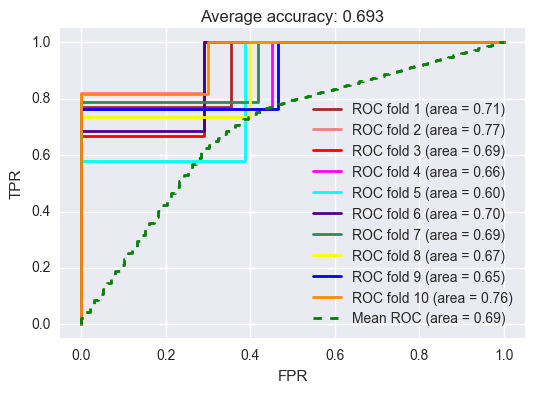

In [17]:
knneigh = KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='uniform')
print(algorithm(knneigh,colors,crx_train,crx_test,pos = None))

('Average accuracy: 0.779 (+/-0.003)', '\n Confustion Matrix:', array([[22949,   415],
       [ 6216,   420]]))


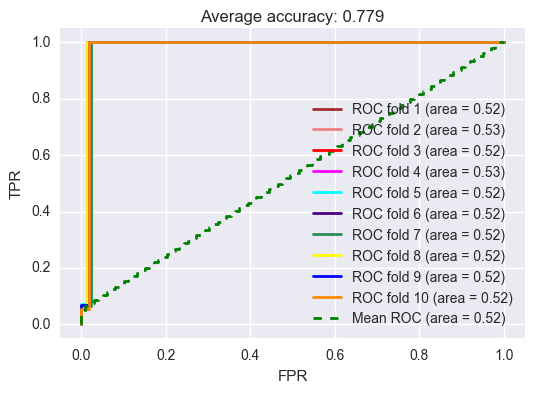

In [18]:
knneigh = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
           weights='uniform')
print(algorithm(knneigh,colors,default_train,default_test,pos = None))

Support Vector Machines

('Average accuracy: 0.760 (+/-0.034)', '\n Confustion Matrix:', array([[621,  79],
       [161, 139]]))


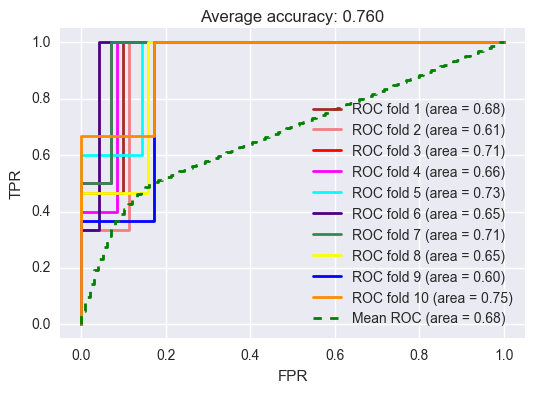

In [19]:
svm = LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=1000, tol=0.0001,
     verbose=0)
print(algorithm(svm,colors,german_train,german_test,pos = 2))

('Average accuracy: 0.856 (+/-0.040)', '\n Confustion Matrix:', array([[282,  25],
       [ 74, 309]]))


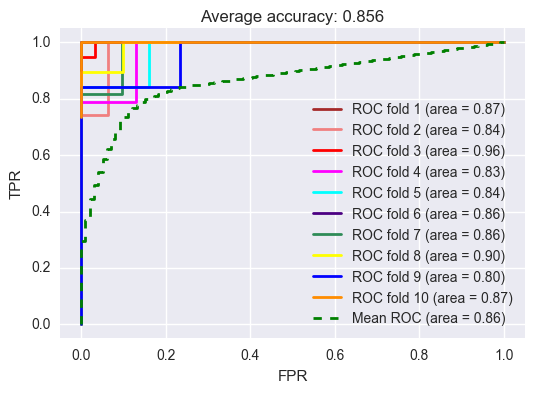

In [20]:
svm = LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=500,
     multi_class='ovr', penalty='l2', random_state=1000, tol=0.0001,
     verbose=0)
print(algorithm(svm,colors,crx_train,crx_test,pos = None))

('Average accuracy: 0.804 (+/-0.002)', '\n Confustion Matrix:', array([[22928,   436],
       [ 5452,  1184]]))


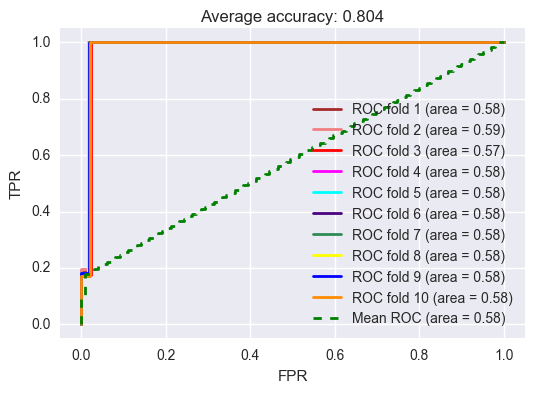

In [21]:
svm = LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10,
     multi_class='ovr', penalty='l1', random_state=1000, tol=0.0001,
     verbose=0)
print(algorithm(svm,colors,default_train,default_test,pos = None))